<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Strato75/Covid-19_ItalyStats/blob/master/notebooks/global_world_stats.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" />Run in Google Colab</a>
  </td>
</table>

International data taken from:
https://github.com/CSSEGISandData/COVID-19

In [21]:
%pylab inline
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

Populating the interactive namespace from numpy and matplotlib


In [26]:
### Globals
x_tick_rot = 90
x_tick_fs = 4
ms = 2
marker_l = ['o', '^', 'x', 's', 'v', '+', 'p']

### Functions 
def get_data_from_df(df):
    df = df.iloc[:, 4:].fillna(0)    
    df = df.loc[:,:].astype('int32')
    s = df.sum()
    vals = s.values
    x = df.columns
    
    return x, vals


def get_xdata(x):
    return ['%02d-%02d' % (i.date().month, i.date().day) for i in x.to_list()]


def sum_per_group(raw_groupby_df, group):
    df = raw_groupby_df.get_group(group)
    df = df.iloc[:, 4:]    
    df = df.loc[:,:].astype('int32')
    s = df.sum()
    vals = s.values
    x = df.columns

    return x, vals


def plot_group(raw_df, g, min_val=0, fig_title=''):
    ax = plt.gca()
    if not isinstance(g, list):
        g = [g]

    raw_groupby_df = raw_df.fillna(0).groupby("Country/Region")

    title_grp = []

    for l_index, group in enumerate(raw_groupby_df.groups):
        x, vals = sum_per_group(raw_groupby_df, group)
        if group in g and max(vals) >= min_val:
            #x = get_xdata(pd.to_datetime(x))
            x = pd.to_datetime(x)
            ax.plot(x, vals, marker=marker_l[l_index%(len(marker_l))], ms=ms, label='%s: %d' % (group, max(vals)))
            title_grp.append(group)
            
    #_ = plt.xticks(rotation=x_tick_rot, fontsize=x_tick_fs)
    _ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
    _ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
    _ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)
    
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('# People')
    plt.ylim(bottom=0)

    plt.title(fig_title)

    return title_grp

def plot_gradient_group(raw_df, g, min_val=0, fig_title='', sliding_win_size=11, polynomial_fit_degree=3):
    ax = plt.gca()
    if not isinstance(g, list):
        g = [g]

    raw_groupby_df = raw_df.fillna(0).groupby("Country/Region")

    title_grp = []

    max_grad = 0

    for l_index, group in enumerate(raw_groupby_df.groups):
        x, vals = sum_per_group(raw_groupby_df, group)
        grad = np.gradient(vals)
        grad_hat = savgol_filter(grad, sliding_win_size, polynomial_fit_degree) 

        if group in g and max(vals) >= min_val:
            #plot(x, grad, label='%s: Actual' % group)
            #x = get_xdata(pd.to_datetime(x))
            x = pd.to_datetime(x)
            ax.plot(x, grad_hat, marker=marker_l[l_index%(len(marker_l))], ms=ms, label='%s' % group)
            title_grp.append(group)

        #_ = plt.xticks(rotation=x_tick_rot, fontsize=x_tick_fs)
    _ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
    _ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
    _ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)
    plt.legend()
    plt.grid()
    plt.xlabel('Date')
    plt.ylabel('Derivative (people per day)')
    plt.ylim(bottom=0)

    plt.title(fig_title)


def plot_fatality_rate(raw_confirmed_df, raw_deaths_df, g, min_val=0, fig_title='', sliding_win_size=11, polynomial_fit_degree=3):
    if not isinstance(g, list):
        g = [g]

    raw_confirmed_groupby_df = raw_confirmed_df.fillna(0).groupby("Country/Region")
    raw_deaths_groupby_df = raw_deaths_df.fillna(0).groupby("Country/Region")

    title_grp = []

    for l_index, group in enumerate(raw_confirmed_groupby_df.groups):
        x_c, vals_c = sum_per_group(raw_confirmed_groupby_df, group)
        x_d, vals_d = sum_per_group(raw_deaths_groupby_df, group)

        a = vals_d.astype(np.float32)
        b = vals_c.astype(np.float32)

        # Returns 0 if confirmed is 0
        ratio = np.divide(a, b, out=np.zeros_like(a), where=b!=0) 
        ratio_hat = savgol_filter(ratio, sliding_win_size, polynomial_fit_degree) 

        if group in g and max(ratio) >= min_val:
            #plot(x, grad, label='%s: Actual' % group)
            plt.plot(x_c, ratio_hat, marker=marker_l[l_index%(len(marker_l))], ms=ms, label='%s' % group)
            title_grp.append(group)

    plt.legend()
    plt.grid()
    plt._ = xticks(rotation=90, fontsize=x_tick_fs)
    plt.xlabel('Date')
    plt.ylabel('Fatality rate')
    plt.ylim(0, 0.1)
    plt.title(fig_title)

In [23]:
# data from https://github.com/CSSEGISandData/2019-nCoV

raw_confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
raw_recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
raw_death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

xc, confirmed_vals = get_data_from_df(raw_confirmed_df) 
xd, death_vals = get_data_from_df(raw_death_df)
xr, recovered_vals = get_data_from_df(raw_recovered_df)

xc = pd.to_datetime(xc)
xd = pd.to_datetime(xd)
xr = pd.to_datetime(xr)

# Parameters for savgol filter (Smooting curves)
sliding_win_size = 15
polynomial_fit_degree = 3

### Global Statistics 

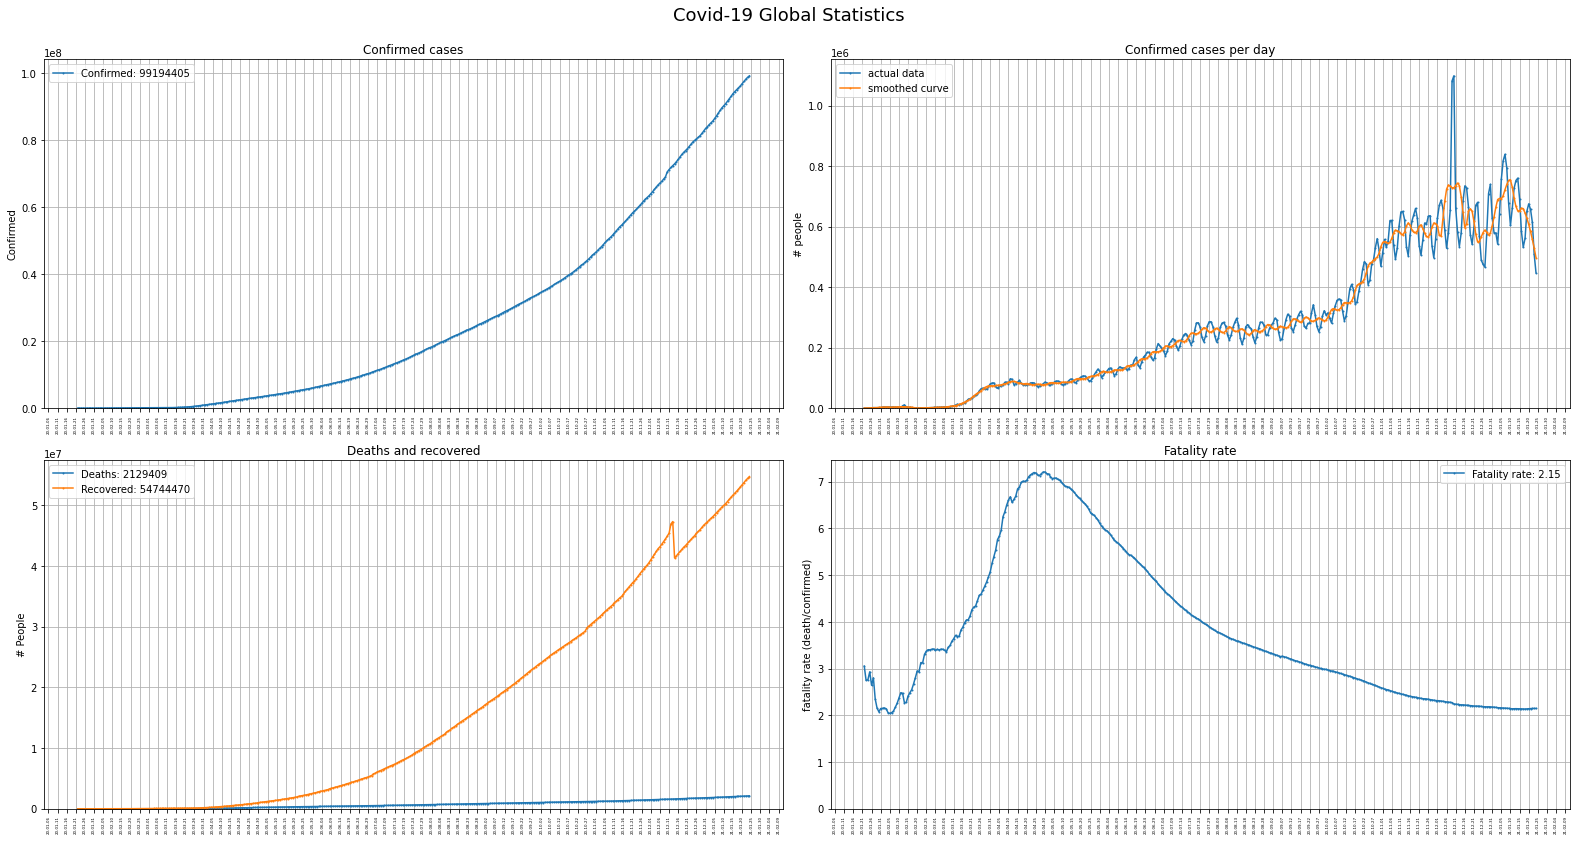

In [18]:
death_vals_hat = savgol_filter(death_vals, sliding_win_size, polynomial_fit_degree) # window size, polynomial order 
recovered_vals_hat = savgol_filter(recovered_vals, sliding_win_size, polynomial_fit_degree) # window size, polynomial order

fig, axs = plt.subplots(2,2,figsize=(22,12))

ax = axs[0,0]
ax.plot(xc, confirmed_vals, '-o', ms=1, label='Confirmed: %d' % confirmed_vals[-1])
ax.set_ylabel("Confirmed")
ax.set_ylim(bottom=0)
ax.set_title('Confirmed cases')
ax.grid()
ax.legend()
#_ = plt.xticks(rotation=x_tick_rot, fontsize=x_tick_fs)
_ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
_ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)

ax = axs[0,1]
confirmed_grad = np.gradient(confirmed_vals)
confirmed_grad_hat = savgol_filter(confirmed_grad, sliding_win_size, polynomial_fit_degree) 

ax.plot(xc, confirmed_grad, '-o', ms=1, label='actual data')
ax.plot(xc, confirmed_grad_hat, '-o', ms=1, label='smoothed curve')
ax.set_ylabel("# people")
ax.set_ylim(bottom=0)
ax.set_title('Confirmed cases per day')
ax.grid()
ax.legend()
_ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
_ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)

ax = axs[1,0]
ax.plot(xd, death_vals, '-o', ms=1, label='Deaths: %d' % death_vals[-1])
ax.plot(xr, recovered_vals, '-o', ms=1, label='Recovered: %d' % recovered_vals[-1])
ax.set_ylabel('# People')
ax.set_ylim(bottom=0)
ax.set_title('Deaths and recovered')
ax.grid()
ax.legend()
_ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
_ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)

ax = axs[1,1]
x_ratio = []
ratio_vals = []
for i, x in enumerate(xd):
    if x in xr:
        ir = xr.get_loc(x)
        x_ratio.append(x)
        ratio_vals.append(death_vals[i] / (confirmed_vals[i])* 100)
ax.plot(xd, ratio_vals, '-o', ms=1, label='Fatality rate: %.2f' % ratio_vals[-1])
ax.set_ylabel("fatality rate (death/confirmed)")
ax.set_ylim(bottom=0)
ax.set_title('Fatality rate')
ax.legend()
ax.grid()
_ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d')) 
_ = ax.xaxis.set_major_locator(plt.MaxNLocator(90))
_ = plt.setp(ax.get_xticklabels(), rotation = 90, fontsize=x_tick_fs)

plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Covid-19 Global Statistics", fontsize=18)

fig.savefig('figures/global_resume.png', dpi=300, transparency=False, bbox_inches='tight')

### Per Nation Plots

In [24]:
min_val = 2000000 # Set here the minimum number of total case a nation must have to plot its data

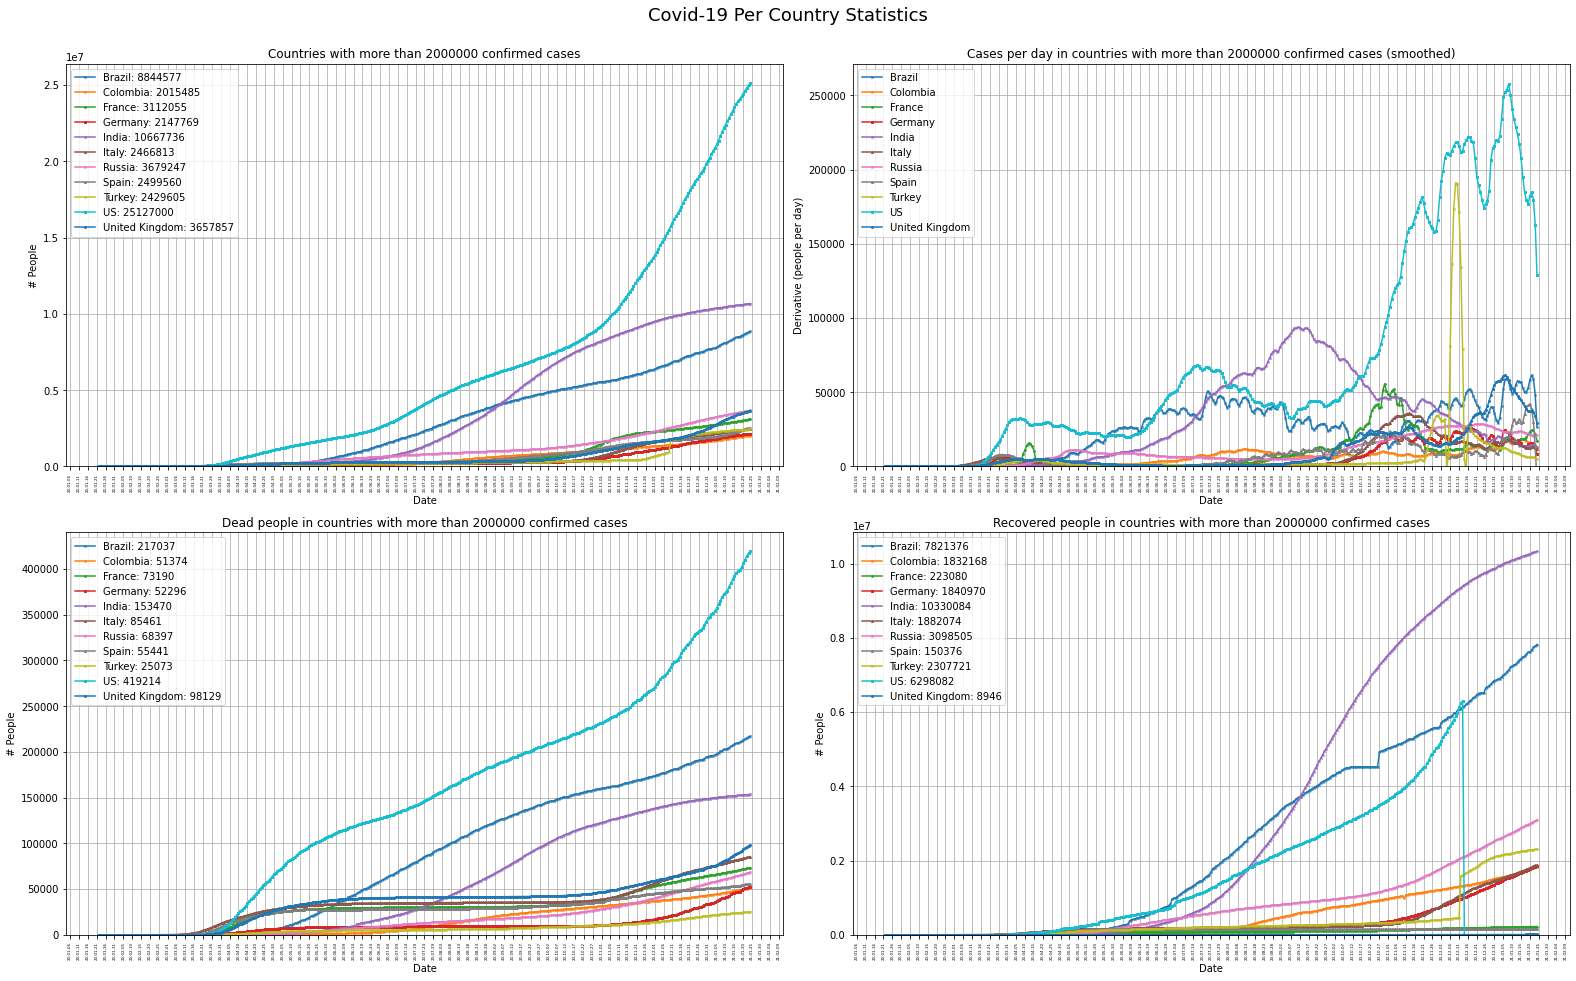

In [27]:
## Nation with confirmed cases larger than 2000000 people
grps = raw_confirmed_df.fillna(0).groupby("Country/Region").groups.keys()
g = [i for i in grps]

fig=figure(figsize=(22,14))
subplot(2,2,1)
countries = plot_group(raw_confirmed_df, g, min_val=min_val, fig_title='Countries with more than %d confirmed cases' % min_val)

subplot(2,2,2)
plot_gradient_group(raw_confirmed_df, g, min_val= min_val, fig_title='Cases per day in countries with more than %d confirmed cases (smoothed)' % min_val)

subplot(2,2,3)
# Deaths of previously analyzed countries
plot_group(raw_death_df, g = countries, fig_title='Dead people in countries with more than %d confirmed cases' % min_val)

subplot(2,2,4)
# Recovered  of previously analyzed countries
plot_group(raw_recovered_df, g = countries, fig_title='Recovered people in countries with more than %d confirmed cases' % min_val)


plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.suptitle("Covid-19 Per Country Statistics", fontsize=18)

fig.savefig('figures/countries_resume.png', dpi=300, transparency=False, bbox_inches='tight')

### Today situation in the whole World

In [ ]:
today_col = raw_confirmed_df.columns[-1]
tmp_df = raw_confirmed_df[['Province/State', 'Country/Region', today_col]]
tmp_df.sort_values(by=[today_col], inplace=True)
tmp_df = tmp_df[tmp_df[today_col] > 50000]
# Remove countries with less than 

tmp_df['Complete_Name'] = tmp_df[tmp_df.columns[:-1]].apply(lambda x: '_'.join(x.dropna()), axis=1) 


In [ ]:
tmp_df.plot.bar(x='Complete_Name', y=today_col, rot=90, figsize=(20,20))
grid()